# Linear Regression
Haytham Mohamed

INFS 890 - Spring 2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.2f}'.format

NameError: name 'tf' is not defined

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [42]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'



test_split = 0.1

In [43]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [44]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

,front-end_cpu_use,orders_cpu_use,orders-db_cpu_use,user_cpu_use,user-db_cpu_use,shipping_cpu_use,payment_cpu_use,carts_cpu_use,carts-db_cpu_use,front-end_pods,orders_pods,user_pods,shipping_pods,payment_pods,carts_pods,nodes_cpu_use,orders_req,orders_ltcy
0,0.07,0.02,0.01,0.02,0.02,0.01,0.01,0.12,0.16,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.40,0.63
1,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.14,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.18,0.44,0.62
2,0.06,0.03,0.01,0.02,0.02,0.01,0.01,0.15,0.14,1.00,1.00,1.00,1.00,1.00,1.00,1.15,0.36,0.62
3,0.09,0.03,0.01,0.02,0.02,0.01,0.01,0.06,0.19,1.00,1.00,1.00,1.00,1.00,1.00,1.54,0.40,0.56
4,0.11,0.04,0.01,0.03,0.03,0.01,0.01,0.11,0.32,1.00,1.00,1.00,1.00,1.00,1.00,2.35,0.78,0.53


In [45]:
data.shape

(1499, 18)

In [46]:
targets = data['orders_ltcy']

inputs = data.drop(['orders_ltcy'], axis=1)
#inputs = inputs.drop(['date'], axis=1)

n_features = inputs.values.shape[1]

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max

print("there are {} features".format(n_features))

there are 17 features


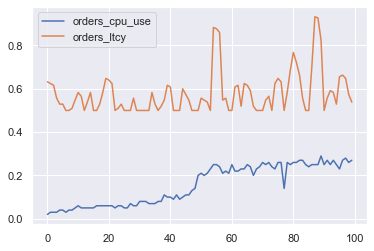

In [47]:
#plt.scatter(data['orders_cpu_use'], data['orders_ltcy'])
#plt.xlabel('orders_cpu_use', size=18)
#plt.ylabel("orders_ltcy", size=18)
#plt.show()

# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][:100], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][:100], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Regression with Feature Selection

In [48]:
x_train_select=x_train
y_train_select=y_train
x_train_select.shape


(1349, 17)

In [49]:
# -- trying features selection 1
if 1 == 0:
    selector = feature_selection.SelectKBest(feature_selection.f_regression).fit(x_train_select, y_train_train)
    selectedFeatures = selector.transform(x_train_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [50]:
# -- trying features selection 2
if 1 == 0:

    thresholds = ['3*mean', '2*mean', 'mean', '0.25*mean', '0.05*mean']
    #max_features=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    
    selection = 4
    
    lasso = LassoCV(fit_intercept=False, tol=0.00000000000001,n_jobs=-1,random_state=365
                    ,selection='random', max_iter=1000000000, positive=False, cv=10)

    #sfm = SelectFromModel(lasso, threshold=-np.inf, max_features=max_features[3]) #(reg, threshold=0.01)
    sfm = SelectFromModel(lasso, threshold=thresholds[selection]) #(lasso, threshold=0.01)

    selectedFeatures = sfm.fit(x_train_select, y_train_select).transform(x_train_select)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))


In [51]:
# -- trying features selection 3
if 1 == 0:
    thresholds = ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean']
    clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)

    sfm = SelectFromModel(clf,threshold=thresholds[0])

    selectedFeatures = sfm.fit(x_train_select, y_train_select).transform(x_train_select)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

In [52]:
#Features selected
if 1 == 0:
    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train_select[feature_list]
    reduced_x_train.head(2)

# Model

In [53]:
# start:  search grid

reg = LinearRegression(normalize=False) # normalize false bacause we are going to use the scaler

# standardize the features
scaler = StandardScaler()
#scaler.fit(x_train.values.reshape(-1,n_features))

# features selection
lasso = LassoCV(fit_intercept=False, tol=0.00000000000001,n_jobs=-1,random_state=365
                    ,selection='random', max_iter=1000000000, positive=False, cv=10)
    
sfm = SelectFromModel(lasso)

pipe = Pipeline(steps=[
    ('scaler', scaler),
    ('selector', sfm), 
    ('reg', reg)
])

kfold = KFold(n_splits=2, shuffle=False)

param_grid = {
    'selector__threshold': ['mean', '0.25*mean', '0.05*mean']
    #'selector__max_features': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
    , 'reg__normalize': [False]
}

search = GridSearchCV(pipe
                      , param_grid
                      , scoring='neg_mean_squared_error'
                      , return_train_score= True
                      , cv=kfold
                      , verbose=1
                      , n_jobs=-1)

search.fit(x_train, y_train)


Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


KeyboardInterrupt: 

# Best Model

In [ ]:
estimator = search.best_estimator_
params = search.best_params_
score = search.best_score_

print("Best CV score = %0.3f:" % score)
print("Best CV params = {}".format(params))

print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")
print(all_training_scores['mean_train_score'])


# Features Selected

In [ ]:
sfm = pipe['selector']

selectedFeatures = sfm.fit(x_train_select, y_train_select).transform(x_train_select)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train_select.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train_select[feature_list]
reduced_x_train.head(2)

In [ ]:
pdf = pd.DataFrame(all_training_scores['mean_train_score'], columns=['training mse'])
pdf.plot()

# Training R2

In [ ]:
y_hat = estimator.predict(x_train)

r2_train = metrics.r2_score(y_train, y_hat)
print('R2 (training) = {}'.format(r2_train))

#print("score ", search.score(x_test, y_test))
# or also R-Squared could be obtain via
#pline.score(x_train, y_train)

In [ ]:
print('Score (training) = {}'.format(search.score(x_train,y_train)))

In [ ]:
estimator.fit(x_train, y_train)

estimator.named_steps.reg.intercept_

In [ ]:
estimator.named_steps.reg.coef_

In [ ]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

In [ ]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

In [ ]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

# Testing

In [ ]:
y_hat_test = estimator.predict(x_test)

In [ ]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

In [ ]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [ ]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

In [ ]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

In [ ]:
perf.describe()

In [ ]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

# *** Prediction Accuracy

In [ ]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

In [ ]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

# What features selected

In [ ]:
x_train.shape

In [ ]:
#reg = LassoCV()
#sfm = SelectFromModel(reg, threshold=0.001)

#sfm = SelectFromModel(
#                RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15),
#                threshold=threshold_selected)


threshold_selected = params['selector__threshold']
sfm = pipe['selector']

selectedFeatures = sfm.fit(inputs, targets).transform(inputs)
print('{} features selected'.format(selectedFeatures[1].shape[0]))

feature_list = x_train.columns[sfm.get_support()]
features = ''
features = ', '.join(feature_list)
#features

reduced_x_train = x_train[feature_list]
reduced_x_train.head(2)

# Trying with Polynomial features 

In [ ]:
if True:
    from sklearn.preprocessing import PolynomialFeatures
    
    degree = 2

    # covert input data to polynomial form of some degree
    inputs_poly = PolynomialFeatures(degree=degree).fit_transform(inputs).astype(float)

    x_train, x_test, y_train, y_test = \
        train_test_split(inputs_poly, targets, test_size=test_split, shuffle=False, random_state=365)

    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


    reg = LinearRegression(normalize=False) # normalize false bacause we are going to use the scaler

    scaler = StandardScaler()

    pipe = Pipeline(steps=[
        ('scaler', scaler),
        ('selector', sfm), 
        ('reg', reg)
    ])

    kfold = KFold(n_splits=10, shuffle=False)

    param_grid = {
        'selector__threshold': ['.1*mean', '.08*mean', '.05*mean', '.02*mean', '.001*mean']
        ,'reg__normalize': [False, True]
    }

    search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

    search.fit(x_train, y_train)

    y_hat_test = search.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))


# Robust Linear Model

In [ ]:
# RANSAC is an iterative algorithm for the robust estimation of parameters from a subset 
# of inliners from the complete data set.
# you can use this with all dataset including outliers
if False:    
    from sklearn.linear_model import RANSACRegressor

    ransac = RANSACRegressor(estimator)
    ransac.fit(x_train, y_train)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)

    y_hat_test = ransac.predict(x_test)

    r2_test = metrics.r2_score(y_test, y_hat_test)
    print('R2 (testing) = {}'.format(r2_test))